## Import

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import random
from torch.nn import CrossEntropyLoss
from tqdm import trange
from torchvision import models
from torch import nn
from torch.optim import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from captum.attr import LayerGradCam, LayerAttribution



## Load

In [ ]:
def image_to_array(address_excel,image_size,address_img):
  df=pd.read_excel(address_excel)
  img_size=(244,244)
  images=[]
  for i in range(150):
    filename=df.iloc[i,0]
    if 'Normal' in address_excel:
     filename=filename[:1]+filename[1:6].lower()+filename[6:]

    try:
      img=Image.open(address_img+filename+'.png')
      img=img.resize(img_size)
      img_array=np.array(img)/255.0
      images.append(img_array)
      images_array=np.array(images)
    except:
      pass
  return (images_array)

This section loads and processes images from four different classes — Normal, Viral Pneumonia, Lung Opacity, and COVID-19 — by reading their filenames from respective metadata Excel files and converting the images into normalized NumPy arrays using the image_to_array function.

In [ ]:
normal='/content/drive/MyDrive/covid_data/COVID-19_Radiography_Dataset/Normal.metadata.xlsx'
images_folder='/content/drive/MyDrive/covid_data/COVID-19_Radiography_Dataset/Normal/images/'
img_size=(244,244)

images_normal=image_to_array(normal,img_size,images_folder)


In [ ]:
#pneumonia='/content/drive/MyDrive/covid_data/COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx'
#images_folder_pnm='/content/drive/MyDrive/covid_data/COVID-19_Radiography_Dataset/Viral Pneumonia/images/'

#images_pnm=image_to_array(pneumonia,img_size,images_folder_pnm)

In [ ]:
#lung_opac='/content/drive/MyDrive/covid_data/COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx'
#image_folder_opac='/content/sample_data/covid_data/MyDrive/covid_data/COVID-19_Radiography_Dataset/Lung_Opacity/images/'

#images_opac=image_to_array(lung_opac,img_size,image_folder_opac)

In [ ]:
covid='/content/drive/MyDrive/covid_data/COVID-19_Radiography_Dataset/COVID.metadata.xlsx'
image_folder_covid='/content/drive/MyDrive/covid_data/COVID-19_Radiography_Dataset/COVID/images/'

images_covid=image_to_array(covid,img_size,image_folder_covid)


This function prepares the dataset for binary classification between COVID-19 and Normal classes. It assigns numeric labels (0 for COVID, 1 for Normal), concatenates the image data and labels, and returns them in a dictionary format.

If desired, the commented lines can be reactivated to include all four classes (COVID-19, Viral Pneumonia, Lung Opacity, and Normal). In this project, only two classes were used due to certain limitations.

In [ ]:
def data_labels(data1,data4):
  label_map={
      'covid':0,
      #'pnm':1,
      #'opac':2,
      'normal':1
  }

  label1=[label_map['covid']]*len(data1)
  #label2=[label_map['pnm']]*len(data2)
  #label3=[label_map['opac']]*len(data3)
  label4=[label_map['normal']]*len(data4)
  all_data = np.concatenate([data1, data4], axis=0)
  all_labels = np.array(label1   + label4)
  data_dict = {
        'data': all_data,
        'labels': all_labels,
        'label_map': label_map
    }

  return data_dict






In [ ]:
data_dict = data_labels(images_covid, images_normal)


This line creates a reverse mapping (index_to_label) from numerical labels back to their original class names, based on the label_map defined earlier. It is useful for interpreting model predictions.

In [ ]:
index_to_label={j:i for i,j in data_dict['label_map'].items()}

This code applies the t-SNE algorithm to reduce the dimensionality of the image data for visualization in 2D. It plots the images from each class (COVID and Normal) in a scatter plot, with points color-coded according to their class label. The index_to_label mapping is used to label the classes in the legend.

## preprcoess

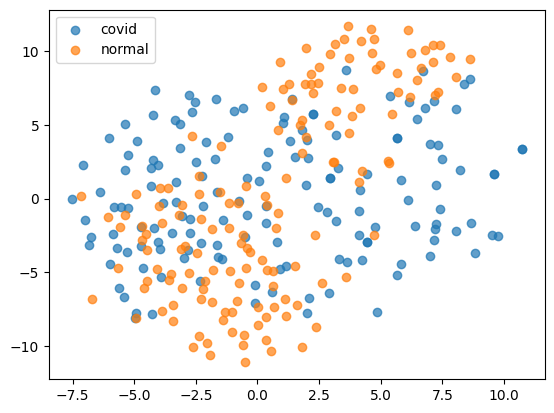

In [ ]:
for i in range(2):
  tf=data_dict['labels']==i
  data=data_dict['data'][tf]
  tsne=TSNE(n_components=2).fit_transform(data.reshape(data.shape[0],-1))
  plt.scatter(tsne[:,0],tsne[:,1],alpha=0.7,label=index_to_label[i])

plt.legend()

That show we have good distribiution , because that is mostly seprated

Text(0, 0.5, 'Count')

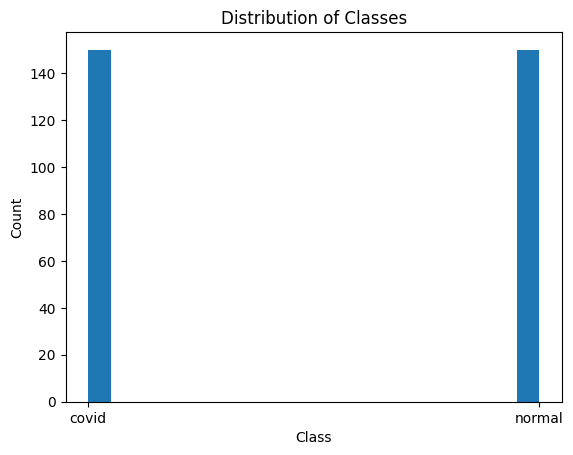

In [ ]:
#data_dict['labels'] == 0

len_0 = np.array(data_dict['labels'][data_dict['labels'] == 0])
len_1 = np.array(data_dict['labels'][data_dict['labels'] == 1])



dist_data=np.concatenate((len_0,len_1))

plt.hist(dist_data,bins=20)
plt.xticks([0,1],['covid','normal'])
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')

so good!!!!

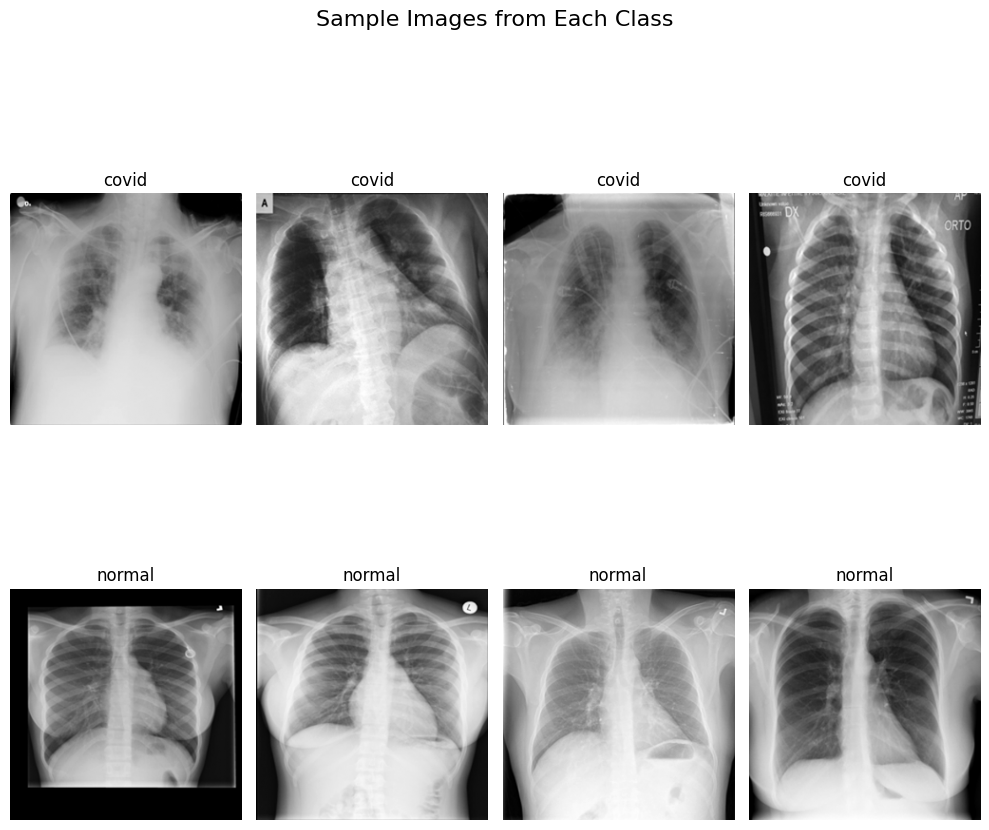

In [ ]:

def show_samples(data_dict, index_to_label):
    fig, axs = plt.subplots(2, 4, figsize=(10, 10))
    fig.suptitle('Sample Images from Each Class', fontsize=16)

    for class_index in range(2):
        tf = data_dict['labels'] == class_index
        images = data_dict['data'][tf][:4]
        for j in range(4):
            ax = axs[class_index, j]
            img = images[j]


            if img.ndim == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)

            ax.set_title(index_to_label[class_index])
            ax.axis('off')

    plt.tight_layout()
    plt.show()

show_samples(data_dict, index_to_label)


This code splits the dataset into training, validation, and test sets. First, it divides the data into 90% training and 10% test. Then, it further splits the test set into validation and test sets (approximately 22% for validation and 78% for testing). The splitting is done randomly, with the same random state for reproducibility.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_dict['data'], data_dict['labels'], test_size=0.1, random_state=42,shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.222, random_state=42,shuffle=True)


The original X_train data must have all data points with the same size and model, meaning they should be in RGB format. A series of transformations should be applied to the data to make it ready for the network and learning in both the transform and augmentations functions. The augmented data (X_train_augmented) is then combined with the original X_train to create a unified dataset.

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize((244, 244)),
    transforms.ToTensor()  ])

augmentations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(244),
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize((244, 244)),
    transforms.ToTensor(),
])

processed_images = []
for img in X_train:
    img_fixed = transform(img)
    processed_images.append(img_fixed)

X_train_tensor = torch.stack(processed_images)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

x_train_valid_tensor=torch.stack(processed_images[:40])
y_train_valid_tensor=torch.tensor(y_train[:40], dtype=torch.long)





augmented_images = []
augmented_labels = []

for img, label in zip(X_train, y_train):
    augmented_img = augmentations(img)
    augmented_images.append(augmented_img)
    augmented_labels.append(label)

X_train_augmented_tensor = torch.stack(augmented_images)
y_train_augmented_tensor = torch.tensor(augmented_labels, dtype=torch.long)

X_train_combined = torch.cat([X_train_tensor, X_train_augmented_tensor], dim=0)
y_train_combined = torch.cat([y_train_tensor, y_train_augmented_tensor], dim=0)

train_data_combined = TensorDataset(X_train_combined, y_train_combined)
train_loader_combined = DataLoader(train_data_combined, batch_size=32, shuffle=True)


This code processes the validation set (X_val) in the same way as the training set. Each image is passed through the transform function to convert it to RGB, resize it, and convert it into a tensor. The processed validation images are then stored in X_val_tensor and paired with the corresponding labels (y_val_tensor) to create a TensorDataset. This dataset is loaded into a DataLoader for efficient batching during validation.

In [ ]:
processed_images_val = []
for img in X_val:
    img_fixed = transform(img)
    processed_images_val.append(img_fixed)


X_val_tensor = torch.stack(processed_images_val)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)





val_data = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)

This code processes the test set (X_test) in the same way as the training and validation sets. Each image is transformed using the transform function to convert it to RGB, resize it to the appropriate size, and convert it into a tensor. The processed test images are stored in X_test_tensor and paired with the corresponding labels (y_test_tensor) to create a TensorDataset. This dataset is then wrapped in a DataLoader to allow for efficient batch processing during testing.

In [ ]:
processed_images_test = []
for img in X_test:
    img_fixed = transform(img)
    processed_images_test.append(img_fixed)




X_test_tensor = torch.stack(processed_images_test)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


x_test_main=torch.cat([X_test_tensor,x_train_valid_tensor],dim=0)
y_test_main=torch.cat([y_test_tensor,y_train_valid_tensor],dim=0)

test_data = TensorDataset(x_test_main, y_test_main)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

the function for training the entire training dataset and apply it to the model you're providing.

## functional finction

In [ ]:
def train_epoch(model,optim,dataloader,loss_fn,device,n_epochs):
  model.train()
  train_loss=0
  train_acc=0
  loss_list=[]
  acc_list=[]
  for _ in (pbar := trange(n_epochs)):
    for img,label in dataloader:
      img,label=img.to(device),label.to(device)
      logistic=model(img)
      loss=loss_fn(logistic,label)
      loss.backward()
      optim.step()
      optim.zero_grad()
      train_acc += (logistic.argmax(dim=1)== label).sum().item()
      train_loss /= len(dataloader)
      train_acc /= len(dataloader.dataset)
    loss_list.append(train_loss)
    acc_list.append(train_acc)


  return loss_list,acc_list


In [ ]:

def valid(model,dataloader,loss_fn,device):
  model.eval()
  val_acc=0
  val_loss=0
  all_preds = []
  all_labels = []
  with torch.inference_mode():
    for img,label in dataloader:
      img,label=img.to(device),label.to(device)
      logistic=model(img)
      loss=loss_fn(logistic,label)
      val_loss += loss.item()
      val_acc += (logistic.argmax(dim=1) == label).sum().item()

      all_preds.extend(logistic.argmax(dim=1).cpu().numpy())
      all_labels.extend(label.cpu().numpy())
    val_loss/=len(dataloader)
    val_acc /= len(dataloader.dataset)
    return val_loss,val_acc,all_preds,all_labels



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def confu(lable,pred,acc):
  cm = confusion_matrix(lable, pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["COVID",'Normal'])
  disp.plot(cmap=plt.cm.Blues)
  plt.title(f'Confusion Matrix - Acc: {acc:.2f}')
  return plt.show()





In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


This code snippet modifies the pre-trained ResNet-18 model by freezing all layers except the final fully connected layer and the last block of layers (layer4), allowing for fine-tuning

## Resne-18

In [ ]:
resnet18 = models.resnet18(weights='DEFAULT')
for param in resnet18.parameters():
    param.requires_grad = False


num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 2)
for param in resnet18.fc.parameters():
    param.requires_grad = True

for param in resnet18.layer4.parameters():
    param.requires_grad = True

resnet18 = resnet18.to(device)
if device == 'cuda':
    resnet18 = torch.compile(resnet18)

loss_fn=CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 82.3MB/s]


In [ ]:
optim = Adam(resnet18.parameters(),lr=1e-5)


In [ ]:
loss18,acc18=train_epoch(resnet18,optim,train_loader_combined,loss_fn,device,70)

100%|██████████| 70/70 [01:02<00:00,  1.13it/s]


In [ ]:
loss18_,acc18_,pred18_,label18_=valid(resnet18,val_loader,loss_fn,device)

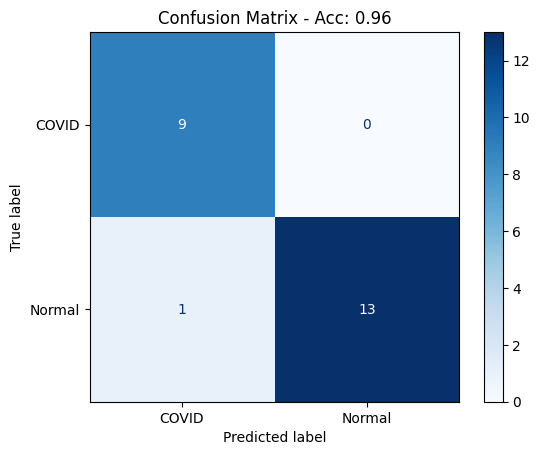

In [ ]:
confu(label18_,pred18_,acc18_)

In [ ]:
loss18_

0.07919947803020477

That is so good result and model don't ovefit

## Resnet 50

The code loads a pre-trained ResNet-50 model, freezes all its layers (prevents updates to their weights during training), and then modifies the final fully connected layer to output 2 classes (for binary classification). The last block (layer4) is unfrozen for fine-tuning.

In [ ]:
resnet50 = models.resnet50(weights='DEFAULT')
for param in resnet50.parameters():
    param.requires_grad = False


num_ftrs50 = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs50, 2)
for param in resnet50.fc.parameters():
    param.requires_grad = True

for param in resnet50.layer4.parameters():
    param.requires_grad = True

resnet50 = resnet50.to(device)
if device == 'cuda':
    resnet50 = torch.compile(resnet50)

In [ ]:
loss50,acc50=train_epoch(resnet50,optim,train_loader_combined,loss_fn,device,200)

100%|██████████| 200/200 [09:37<00:00,  2.89s/it]


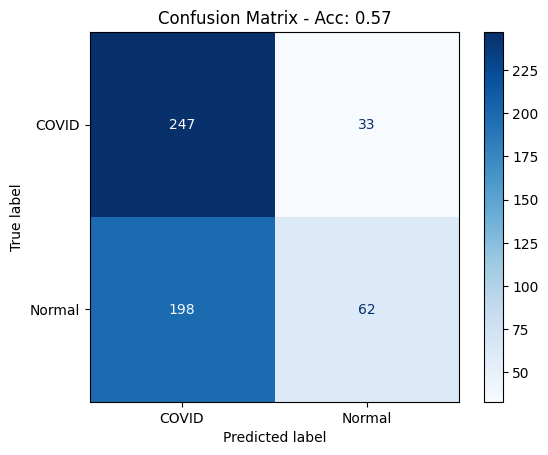

In [ ]:
loss50_,acc50_tr,pred50_tr,label50_tr=valid(resnet50,train_loader_combined,loss_fn,device)
confu(label50_tr,pred50_tr,acc50_tr)

In [ ]:
loss50_,acc50_,pred50_,label50_=valid(resnet50,val_loader,loss_fn,device)

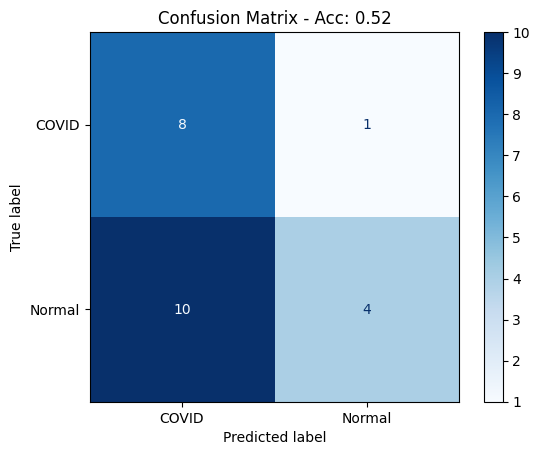

In [ ]:
confu(label50_,pred50_,acc50_)

In [ ]:
loss50_

0.6830258509692024

The ResNet-50 model gave bad accuracy because it is a more complex model compared to ResNet-18 and Since our data was limited, the smaller model produced better results because it converged more easily and effectively.i show accuracy on train data ,because i understand model dont converged or overfit and that 's show ,model did not converged

##Densnet121

In [ ]:
model_dens = models.densenet121(pretrained=True)

for param in model_dens.parameters():
    param.requires_grad = False

for param in model_dens.features.denseblock4.parameters():
    param.requires_grad = True

model_dens.classifier = nn.Linear(model_dens.classifier.in_features, 2)

model_dens.classifier = nn.Linear(model_dens.classifier.in_features, 2)


model_dens.to(device)

In [ ]:
loss_dens_,acc_dens_=train_epoch(model_dens,optim,train_loader_combined,loss_fn,device,100)

100%|██████████| 100/100 [04:15<00:00,  2.55s/it]


In [ ]:
loss_dens,acc_dens,pred_dens,label_dens=valid(model_dens,val_loader,loss_fn,device)

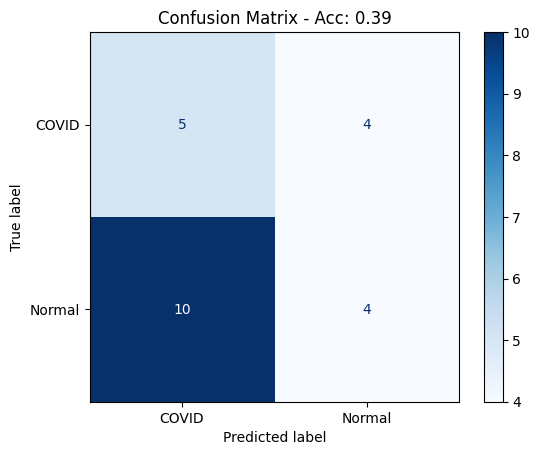

In [ ]:
confu(label_dens,pred_dens,acc_dens)

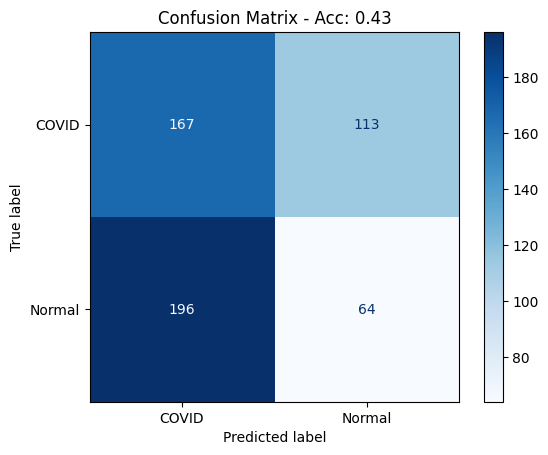

In [ ]:
loss_dens,acc_dens_tr,pred_dens_tr,label_dens_tr=valid(model_dens,train_loader_combined,loss_fn,device)
confu(label_dens_tr,pred_dens_tr,acc_dens_tr)

In [ ]:
loss_dens

0.7600063050494474

i show accuracy on train data ,because i understand model dont converged or overfit and that 's show ,model did not converged


## Eficient tiny

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

efficientnet = models.efficientnet_b0(weights='DEFAULT')

for param in efficientnet.parameters():
    param.requires_grad = False

num_ftrs = efficientnet.classifier[1].in_features
efficientnet.classifier[1] = nn.Linear(num_ftrs, 2)

for param in efficientnet.classifier[1].parameters():
    param.requires_grad = True

for param in efficientnet.features[-1].parameters():  # last block
    param.requires_grad = True

efficientnet = efficientnet.to(device)
if device == 'cuda':
    efficientnet = torch.compile(efficientnet)

loss_fn = CrossEntropyLoss()

optimizer = Adam(filter(lambda p: p.requires_grad, efficientnet.parameters()), lr=1e-4)



In [ ]:
optim = Adam(efficientnet.parameters(),lr=1e-5)


In [ ]:
loss_efficientnet,acc_efficientnet=train_epoch(efficientnet,optim,train_loader_combined,loss_fn,device,50)

100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


In [ ]:
loss_efficientnet,acc_efficientnet,pred_efficientnet,label_efficientnet=valid(efficientnet,val_loader,loss_fn,device)

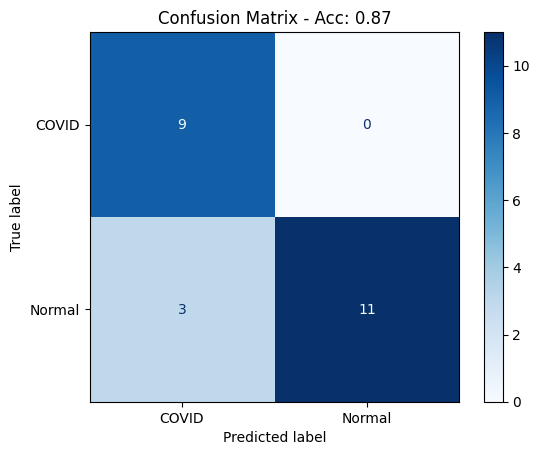

In [ ]:
confu(label_efficientnet,pred_efficientnet,acc_efficientnet)

This model also performed well, and its conditions are very similar to ResNet-18 — meaning it’s a small model.”

## Best

### resenet-18

In [ ]:
loss18,acc18,pred18,label18=valid(resnet18,test_loader,loss_fn,device)

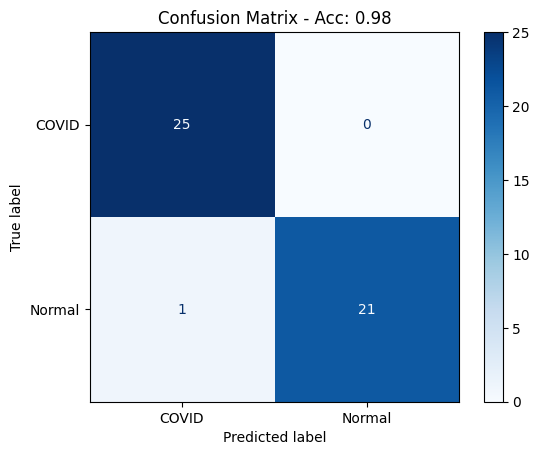

In [ ]:

confu(label18,pred18,acc18)

In [ ]:
! python -m pip install captum

  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you 

In [ ]:
index_to_label[data_dict['labels'][5]]

'covid'

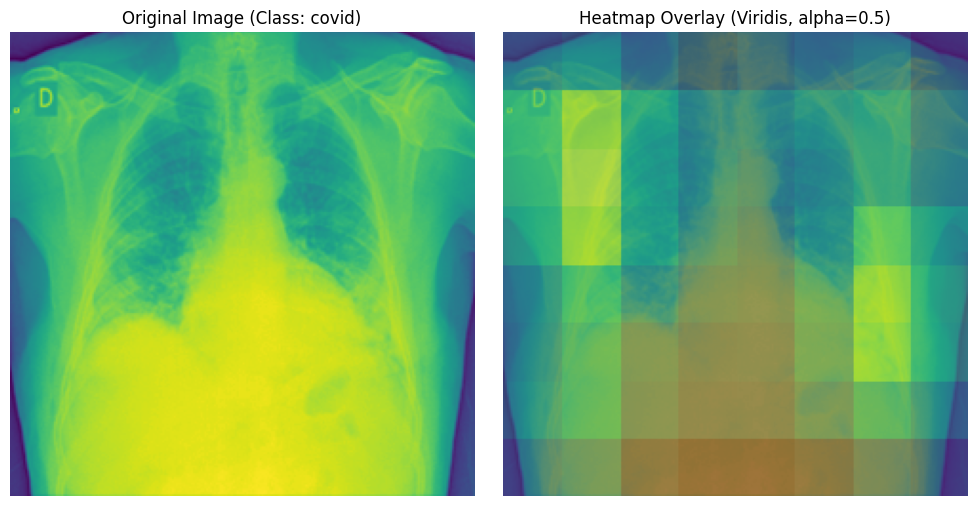

In [ ]:
from captum.attr import LayerGradCam, LayerAttribution

img_index = 5 # covid index
img=data_dict['data'][img_index]
img_tensor=transform(img).unsqueeze(0)
img_tensor=img_tensor.to(device)

img_tensor = img_tensor.float()

target_layer=resnet18.layer4[1].conv2

predict=resnet18(img_tensor.to(device))

class_predict=torch.argmax(predict,dim=1).item()

gradcam = LayerGradCam(resnet18, target_layer)

attr = gradcam.attribute(img_tensor, target=class_predict)


heatmap = LayerAttribution.interpolate(attr, img_tensor.shape[2:])



heatmap = heatmap.squeeze().detach().cpu().numpy()
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8) # Added epsilon to avoid division by zero

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(img)
axs[0].set_title(f'Original Image (Class: {index_to_label[class_predict]})')
axs[0].axis('off')

axs[1].imshow(img)

axs[1].imshow(heatmap, cmap='viridis', alpha=0.5)
axs[1].set_title('Heatmap Overlay (Viridis, alpha=0.5)')
axs[1].axis('off')

plt.tight_layout()
plt.show()

The results showed that ResNet-18, despite being a small model, performs well on the dataset and provides acceptable outcomes. According to the Grad-CAM output, the model focused on the correct regions of the image and made its classifications based on them.

### Efficient

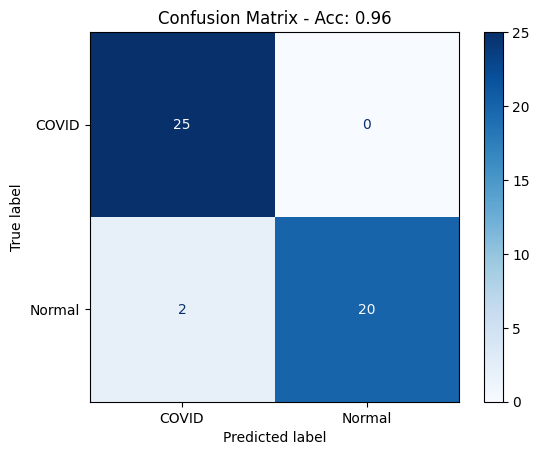

In [ ]:
loss_efficientnet,acc_efficientnet,pred_efficientnet,label_efficientnet=valid(efficientnet,test_loader,loss_fn,device)
confu(label_efficientnet,pred_efficientnet,acc_efficientnet)

In [ ]:
img_index = 5
img = data_dict['data'][img_index]
img_tensor = transform(img).unsqueeze(0)
img_tensor = img_tensor.to(device)
img_tensor = img_tensor.float()

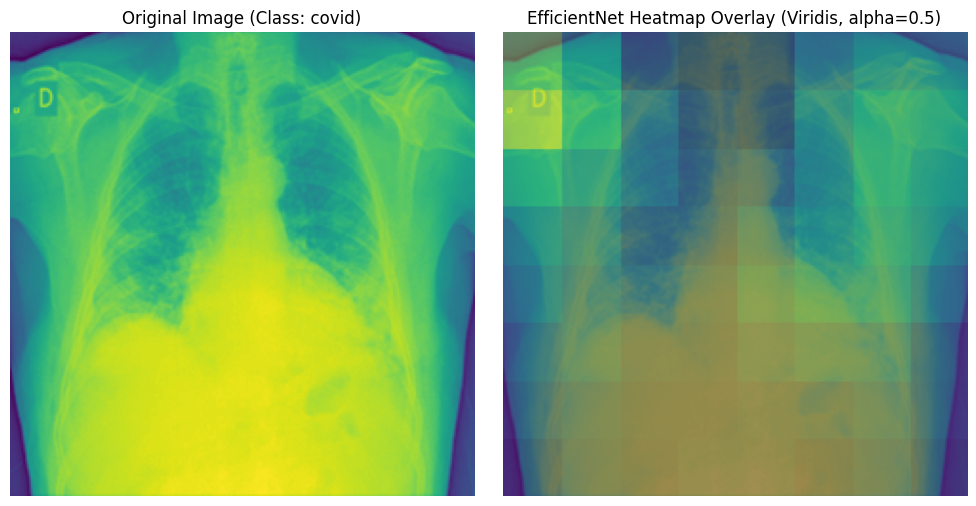

In [ ]:
import torch
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torchvision import models
from captum.attr import LayerGradCam, LayerAttribution
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

efficientnet = models.efficientnet_b0(weights='DEFAULT')

for param in efficientnet.parameters():
    param.requires_grad = False

num_ftrs = efficientnet.classifier[1].in_features
efficientnet.classifier[1] = nn.Linear(num_ftrs, 2)

for param in efficientnet.classifier[1].parameters():
    param.requires_grad = True

for param in efficientnet.features[-1].parameters():  # last block
    param.requires_grad = True

efficientnet = efficientnet.to(device)
efficientnet.eval()

loss_fn = CrossEntropyLoss()
optimizer = Adam(filter(lambda p: p.requires_grad, efficientnet.parameters()), lr=1e-4)

img_index = 5
img = data_dict['data'][img_index]
img_tensor = transform(img).unsqueeze(0)
img_tensor = img_tensor.to(device)
img_tensor = img_tensor.float()

predict = efficientnet(img_tensor)
class_predict = torch.argmax(predict, dim=1).item()


target_layer_efficientnet = efficientnet.features[-1][0]
gradcam_efficientnet = LayerGradCam(efficientnet, target_layer_efficientnet)

attr_efficientnet = gradcam_efficientnet.attribute(img_tensor, target=class_predict)

heatmap_efficientnet = LayerAttribution.interpolate(attr_efficientnet, img_tensor.shape[2:])

heatmap_efficientnet = heatmap_efficientnet.squeeze().detach().cpu().numpy()
heatmap_efficientnet = (heatmap_efficientnet - heatmap_efficientnet.min()) / (heatmap_efficientnet.max() - heatmap_efficientnet.min() + 1e-8)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(img)
axs[0].set_title(f'Original Image (Class: {index_to_label[class_predict]})')
axs[0].axis('off')

axs[1].imshow(img)
axs[1].imshow(heatmap_efficientnet, cmap='viridis', alpha=0.5)
axs[1].set_title('EfficientNet Heatmap Overlay (Viridis, alpha=0.5)')
axs[1].axis('off')

plt.tight_layout()
plt.show()

EfficientNet also has conditions similar to ResNet-18, but there is an important point regarding EfficientNet: this model cannot become our ideal and final model — and I explain the reason for that in the next section.

## Intresting

100%|██████████| 70/70 [01:12<00:00,  1.04s/it]


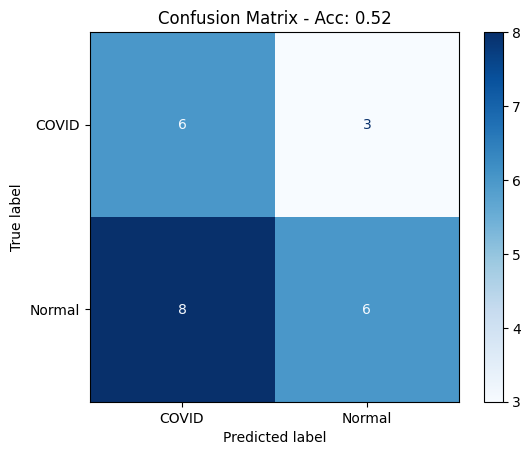

In [ ]:
loss_efficientnet,acc_efficientnet=train_epoch(efficientnet,optim,train_loader_combined,loss_fn,device,70)
loss_efficientnet,acc_efficientnet,pred_efficientnet,label_efficientnet=valid(efficientnet,val_loader,loss_fn,device)
confu(label_efficientnet,pred_efficientnet,acc_efficientnet)

!!!!!!!!!!!!!!   BIIIIIIIGG OVEEEERRR FIIIIIIIIITTTTTT

The EfficientNet model starts to overfit after just a slightly higher number of epochs, which makes it less reliable. In contrast, ResNet-28 trains easily with the same number of epochs with out overfit.

## Summery and Result

In today’s world, many people believe that to achieve a better model, you must spend more resources on training, data collection, and so on. But today we showed that even small models can successfully converge on a dataset — even though our dataset was difficult to interpret — and they can work well with limited data (of course, techniques such as data augmentation must be used). Using Grad-CAM, we demonstrated that this small model focused on the correct regions of the images.
So the question is this:
Is it really justified to spend huge amounts of money on large general-purpose models that perform many tasks with only medium or low accuracy and require enormous cost and human effort?
Or should we instead use small models designed for specific tasks that deliver high accuracy with low cost?”